In [1]:
%load_ext lab_black
import numpy as np
import uproot as up
from matplotlib import pyplot as plt
from ipynb.fs.defs.covfit import *
from scipy.stats import chi2

In [2]:
# Load the data

# Data from https://arxiv.org/abs/1002.2680 and https://arxiv.org/abs/1301.7067

files = {
    "Genie_10a": "MB_CC0pi_GENIEv3.00.06_G18_10a_02_11a.root",
    "Genie_10b": "MB_CC0pi_GENIEv3.00.06_G18_10b_00_000.root",
    "Neut": "MB_CC0pi_NEUTv5.4.1.root",
    "NuWro": "MB_CC0pi_NUWROv19.02.2.root",
    "SuSAv2": "SuSAv2MBComp.root",
}

modes = ["nu", "antinu"]

data = {}
MC = {}
MC_scale = {}
var = {}
scale_error = {
    "nu": 0.107,
    "antinu": 0.130,
}
bin_width = {
    "nu": 0.01,  # 1/GeV
    "antinu": 0.01,  # 1/GeV
}

for gen, filename in files.items():
    F = up.open(filename)

    for mode in modes:
        hist = F[f"MiniBooNE_CCQELike_XSec_2DTcos_{mode}_data_1D"]
        data[mode] = hist.numpy()[0]

        cov = F[f"MiniBooNE_CCQELike_XSec_2DTcos_{mode}_COV"]
        var[mode] = np.diag(cov.numpy()[0]) * 1e-76

        # Remove empty bins
        i_good = var[mode] > 0
        print(np.sum(i_good), len(i_good))
        var[mode] = var[mode][i_good]
        data[mode] = data[mode][i_good]

        hist = F[f"MiniBooNE_CCQELike_XSec_2DTcos_{mode}_MC_1D"]
        hist = hist.numpy()[0][i_good]
        scale = np.sum(data[mode]) / np.sum(hist)
        hist *= scale
        MC_scale[(mode, gen)] = scale
        MC[(mode, gen)] = hist

137 360
78 360
137 360
78 360
137 360
78 360
137 360
78 360
137 360
78 360


In [3]:
p_all = {}
# Shape-only p-values
p_all["Shape only"] = {}
for mode in modes:
    p_all["Shape only"][mode] = {}
    for gen in files:
        z = np.sqrt((data[mode] - MC[(mode, gen)]) ** 2 / var[mode])
        p = {}
        p["naive"] = chi2(df=len(z)).sf(naive(z))
        p["fitted"] = BEE2(df=len(z)).sf(fitted(z))
        p["invariant"] = chi2(df=1).sf(invariant3(z, alpha=2 / 3))
        print(f"{mode} {gen}")
        print(p)
        p_all["Shape only"][mode][gen] = p

nu Genie_10a
{'naive': 0.03500781237646278, 'fitted': 0.06894647355533556, 'invariant': 0.06893194958803076}
nu Genie_10b
{'naive': 0.023659884477535857, 'fitted': 0.13974794945345437, 'invariant': 0.1397464883114217}
nu Neut
{'naive': 5.6635981009851196e-09, 'fitted': 0.018074311766623774, 'invariant': 0.018054072236693114}
nu NuWro
{'naive': 2.272376065852769e-05, 'fitted': 0.1299956554392816, 'invariant': 0.12998479641464264}
nu SuSAv2
{'naive': 3.3998252754248045e-24, 'fitted': 0.002472664855930451, 'invariant': 0.0024589452834627807}
antinu Genie_10a
{'naive': 9.924593201669492e-24, 'fitted': 5.070332477652428e-05, 'invariant': 5.050987467740091e-05}
antinu Genie_10b
{'naive': 3.7083273634632995e-23, 'fitted': 7.071927911050935e-05, 'invariant': 7.045015752481324e-05}
antinu Neut
{'naive': 2.815147653268569e-14, 'fitted': 0.0005559077482324426, 'invariant': 0.0005539249211284993}
antinu NuWro
{'naive': 7.323969847719241e-26, 'fitted': 4.236759089215614e-05, 'invariant': 4.22057707

In [4]:
# Fitted scale shape-only p-values
from scipy.optimize import minimize

for mode in modes:
    for gen in files:

        def fun(scale):
            return np.sum((data[mode] - scale * MC[(mode, gen)]) ** 2 / var[mode])

        opt = minimize(fun, 1)
        z = np.sqrt((data[mode] - opt.x * MC[(mode, gen)]) ** 2 / var[mode])
        p = {}
        p["naive"] = chi2(df=len(z) - 1).sf(naive(z))
        p["fitted"] = BEE2(df=len(z)).sf(fitted(z))
        p["invariant"] = chi2(df=1).sf(invariant3(z, alpha=2 / 3))
        print(f"{mode} {gen}")
        print(p)

nu Genie_10a
{'naive': 0.035328081762001154, 'fitted': 0.04164699165457131, 'invariant': 0.0416386570519568}
nu Genie_10b
{'naive': 0.02419467410646877, 'fitted': 0.08686991730892724, 'invariant': 0.0868500639564409}
nu Neut
{'naive': 7.51877701724339e-09, 'fitted': 0.007585440857606818, 'invariant': 0.0075626010648137424}
nu NuWro
{'naive': 3.57744526827105e-05, 'fitted': 0.05670939519943796, 'invariant': 0.05669248987509125}
nu SuSAv2
{'naive': 3.63696054084104e-24, 'fitted': 0.0010478162256990498, 'invariant': 0.001041264671791967}
antinu Genie_10a
{'naive': 2.8361203583913893e-19, 'fitted': 0.0009286589125049316, 'invariant': 0.0009255169180061843}
antinu Genie_10b
{'naive': 1.6376562019731793e-18, 'fitted': 0.0009731417985785473, 'invariant': 0.0009698706135007683}
antinu Neut
{'naive': 5.112842440562914e-11, 'fitted': 0.007216190315459947, 'invariant': 0.007214205474670194}
antinu NuWro
{'naive': 7.058576194505901e-19, 'fitted': 0.0021603620159894588, 'invariant': 0.0021543637603

In [5]:
# Shape & scale p-values
p_all["Shape & norm."] = {}
for mode in modes:
    p_all["Shape & norm."][mode] = {}
    for gen in files:
        z = np.append(
            np.sqrt((data[mode] - MC[(mode, gen)]) ** 2 / var[mode]),
            np.abs(1 - MC_scale[(mode, gen)]) / scale_error[mode],
        )
        p = {}
        p["naive"] = chi2(df=len(z)).sf(naive(z))
        p["fitted"] = BEE2(df=len(z)).sf(fitted(z))
        p["invariant"] = chi2(df=1).sf(invariant3(z, alpha=2 / 3))
        print(f"{mode} {gen}")
        print(p)
        p_all["Shape & norm."][mode][gen] = p

nu Genie_10a
{'naive': 0.0018924255140338085, 'fitted': 0.00027816509502898157, 'invariant': 0.0002763064257232521}
nu Genie_10b
{'naive': 0.002292355898299128, 'fitted': 0.0029588064284179483, 'invariant': 0.002942954593087149}
nu Neut
{'naive': 5.23890388389028e-10, 'fitted': 0.018205032833301993, 'invariant': 0.018184498627095903}
nu NuWro
{'naive': 5.138385042422928e-06, 'fitted': 0.13087954379520772, 'invariant': 0.13086853652293526}
nu SuSAv2
{'naive': 2.1872373850196166e-24, 'fitted': 0.002490691009093937, 'invariant': 0.0024767702252198064}
antinu Genie_10a
{'naive': 6.08505544393828e-26, 'fitted': 5.135335071060343e-05, 'invariant': 5.11548825841695e-05}
antinu Genie_10b
{'naive': 5.578173214822431e-25, 'fitted': 7.162590406417646e-05, 'invariant': 7.13498015830656e-05}
antinu Neut
{'naive': 8.673431208792667e-15, 'fitted': 0.0005630327638977972, 'invariant': 0.0005609985073562618}
antinu NuWro
{'naive': 1.9448228171549118e-26, 'fitted': 4.291075348017426e-05, 'invariant': 4.2

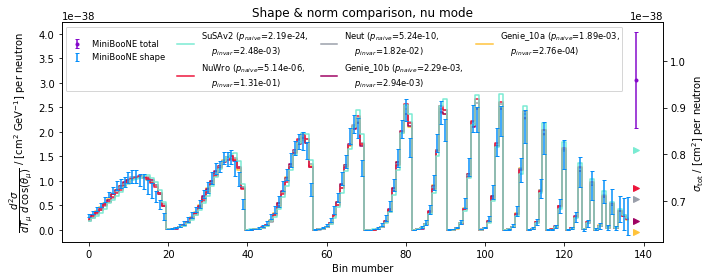

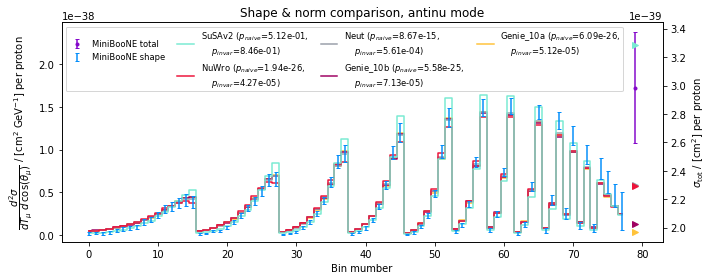

In [6]:
for mode in modes:
    fig, ax = plt.subplots(figsize=(10, 4))
    ax2 = ax.twinx()
    ax.errorbar(
        np.arange(len(data[mode])),
        data[mode],
        np.sqrt(var[mode]),
        linestyle="",
        label="MiniBooNE shape",
        zorder=5,
        capsize=2,
    )
    total = np.sum(data[mode]) * bin_width[mode]  # Bin width
    ax2.errorbar(
        [len(data[mode]) + 1],
        total,
        total * scale_error[mode],
        linestyle="",
        color="C6",
        marker=".",
        label="MiniBooNE total",
        capsize=2,
    )
    for gen in files:
        art = ax.step(
            np.arange(len(MC[(mode, gen)])),
            MC[(mode, gen)],
            where="mid",
            label=gen
            + f" ($p_{{naive}}$={p_all['Shape & norm.'][mode][gen]['naive']:.2e},\n    "
            + f"$p_{{invar}}$={p_all['Shape & norm.'][mode][gen]['invariant']:.2e})",
        )
        ax2.plot(
            [len(data[mode]) + 1],
            total / MC_scale[(mode, gen)],
            marker=">",
            linewidth=2,
            color=art[0].get_color(),
        )
    # ax.set_yscale("log")
    ax.set_ylim(top=ax.get_ylim()[1] * 1.45)
    ax.set_xlabel("Bin mumber")
    if mode == "nu":
        target = "neutron"
    else:
        target = "proton"
    ax.set_ylabel(
        r"$\dfrac{d^2 \sigma}{dT_{\mu}\ d\,\cos(\theta_{\mu})}$ / [cm$^2$ GeV$^{-1}$] per "
        + target
    )
    ax2.set_ylabel(r"$\sigma_{\mathrm{tot}}$ / [cm$^2$] per " + target)
    handles, labels = ax.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(
        handles2[::-1] + handles[::-1],
        labels2[::-1] + labels[::-1],
        loc="upper left",
        ncol=4,
        fontsize="small",
        columnspacing=1.5,
        borderpad=0.3,
    )
    ax.set_title(f"Shape & norm comparison, {mode} mode")
    fig.tight_layout()
    fig.savefig(f"plots/mini-{mode}-norm.pdf")

In [7]:
# Shape & fitted scale p-values
for mode in modes:
    for gen in files:

        def fun(scale):
            return np.sum(
                np.append(
                    np.sqrt((data[mode] - scale * MC[(mode, gen)]) ** 2 / var[mode]),
                    np.abs(1 - scale * MC_scale[(mode, gen)]) / scale_error[mode],
                )
                ** 2
            )

        opt = minimize(fun, 1)
        z = np.append(
            np.sqrt((data[mode] - opt.x * MC[(mode, gen)]) ** 2 / var[mode]),
            np.abs(1 - opt.x * MC_scale[(mode, gen)]) / scale_error[mode],
        )
        p = {}
        p["naive"] = chi2(df=len(z) - 1).sf(naive(z))
        p["fitted"] = BEE2(df=len(z)).sf(fitted(z))
        p["invariant"] = chi2(df=1).sf(invariant3(z, alpha=2 / 3))
        print(f"{mode} {gen}")
        print(p)

nu Genie_10a
{'naive': 0.001584789647843717, 'fitted': 0.00023241502439841355, 'invariant': 0.0002308568083819308}
nu Genie_10b
{'naive': 0.0019542077631411327, 'fitted': 0.002207037873715234, 'invariant': 0.002194392867739277}
nu Neut
{'naive': 4.80098584728172e-10, 'fitted': 0.010658367115845224, 'invariant': 0.010642091134492384}
nu NuWro
{'naive': 5.879887743880619e-06, 'fitted': 0.07254385971811772, 'invariant': 0.07252209825485308}
nu SuSAv2
{'naive': 1.894717314693073e-24, 'fitted': 0.0012680398867968012, 'invariant': 0.0012601864204364098}
antinu Genie_10a
{'naive': 2.0769159222183235e-20, 'fitted': 0.0011627975185228845, 'invariant': 0.0011589396332343075}
antinu Genie_10b
{'naive': 2.236997729348609e-19, 'fitted': 0.0011856916470444068, 'invariant': 0.001181771174037891}
antinu Neut
{'naive': 3.8337700705211517e-11, 'fitted': 0.008093031429157294, 'invariant': 0.008092185724961348}
antinu NuWro
{'naive': 6.563376631816038e-19, 'fitted': 0.002413710684651682, 'invariant': 0.00

In [8]:
# Format p-values
gens = list(files.keys())
print(" & & & " + " & ".join(gens) + r" \\ \hline")
for mode in modes:
    _mode = mode
    for typ in ["Shape & norm.", "Shape only"]:
        _typ = typ
        for stat in ["naive", "invariant"]:
            _stat = stat
            print(
                f"{_mode} & {_typ} & {_stat} & "
                + " & ".join(["%.2e" % (p_all[typ][mode][gen][stat],) for gen in gens])
                + r" \\"
            )
            _stat = ""
            _typ = ""
            _mode = ""

 & & & Genie_10a & Genie_10b & Neut & NuWro & SuSAv2 \\ \hline
nu & Shape & norm. & naive & 1.89e-03 & 2.29e-03 & 5.24e-10 & 5.14e-06 & 2.19e-24 \\
 &  & invariant & 2.76e-04 & 2.94e-03 & 1.82e-02 & 1.31e-01 & 2.48e-03 \\
 & Shape only & naive & 3.50e-02 & 2.37e-02 & 5.66e-09 & 2.27e-05 & 3.40e-24 \\
 &  & invariant & 6.89e-02 & 1.40e-01 & 1.81e-02 & 1.30e-01 & 2.46e-03 \\
antinu & Shape & norm. & naive & 6.09e-26 & 5.58e-25 & 8.67e-15 & 1.94e-26 & 5.12e-01 \\
 &  & invariant & 5.12e-05 & 7.13e-05 & 5.61e-04 & 4.27e-05 & 8.46e-01 \\
 & Shape only & naive & 9.92e-24 & 3.71e-23 & 2.82e-14 & 7.32e-26 & 4.96e-01 \\
 &  & invariant & 5.05e-05 & 7.05e-05 & 5.54e-04 & 4.22e-05 & 8.42e-01 \\
